# Stochastic Gradient Descent

Gradient descent is the workhorse of machine learning. In this workshop we will develop the basic algorithms in the context of two common problems: a simple linear regression and logistic regression for binary classification. This workshop borrows some code from https://am207.github.io/2017/wiki/gradientdescent.html#batch-gradient-descent, and some inspiration from http://www.di.ens.fr/%7Efbach/orsay2018.html.

## Problem #1 - linear regression

To begin, we need some data. We can use the `make_regression()` function from Python machine learning library *scikit-learn* (http://scikit-learn.org) to create a synthetic dataset. For illustrative purposes, we choose a single input variable, but everything we cover applies to higher dimensional data also.

In [31]:
from sklearn.datasets.samples_generator import make_regression 

X, y = make_regression(n_samples=100, 
                       n_features=1,
                       n_informative=1,
                       noise=20,
                       random_state=0)

print(type(X))
print(y.shape)

<class 'numpy.ndarray'>
(100,)


As always, we start by visualising our data. `Matplotlib` is the paramount plotting library in Python, so let's import it into our environment:

In [32]:
import matplotlib.pyplot as plt
# use vector graphics for a crisper plot!
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

Now let's create a scatter plot from our data. A typical workflow is thus:

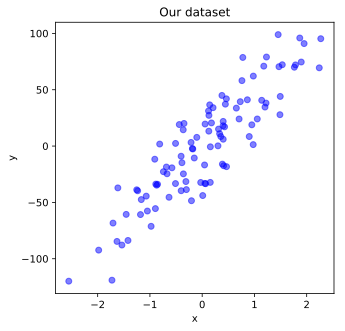

In [33]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='x', ylabel='y')
# plot data on new axis
ax.scatter(X, y, color='blue', alpha=0.5)
ax.set_title('Our dataset')
# display plot
plt.show()

Given our data, a feature matrix of $N$ samples in $d$ dimensions $\mathbf{X} \in \mathbb{R}^{nxd}$ and output vector $y \in \mathbb{R}^{N}$, our objective will be to learn a linear function,

$$\hat{y}_i = \beta_0 + \beta_1x_i$$

such that the sum of square errors $\sum_i(y_i - \hat{y}_i)^2$ is minimised. Each parameter corresponds to a column (feature) of $\mathbf{X}$ and to learn an intercept term also, we append a column of 1s to $\mathbf{X}$. This is called the *bias trick*:

$$
\underbrace{
\begin{bmatrix}
    x_{11} & x_{12} & \dots & x_{1d} \\
    x_{21} & x_{22} & \dots & x_{2d} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{n1} & x_{n2} & \dots & x_{nd}
\end{bmatrix}}_{\mathbf{X}} \to
\underbrace{
\begin{bmatrix}
    1 & x_{11} & x_{12} & \dots & x_{1d} \\
    1 & x_{21} & x_{22} & \dots & x_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{n1} & x_{n2} & \dots & x_{nd}
\end{bmatrix}}_{\text{$\mathbf{X}$ with bias variable}}
$$

$$Pour\ l'output\ de\ notre\ \hat{y}$$

In [34]:
import numpy as np
# augment data with bias trick
N = X.shape[0]
X_bt = np.concatenate([np.ones((N, 1)), X], axis=1)
# print the first few values
print(X_bt[:10])

[[ 1.         -0.35955316]
 [ 1.          0.97663904]
 [ 1.          0.40234164]
 [ 1.         -0.81314628]
 [ 1.         -0.88778575]
 [ 1.          0.44386323]
 [ 1.         -0.97727788]
 [ 1.          0.42833187]
 [ 1.          0.20827498]
 [ 1.         -0.31155253]]


**N.B** In the following we will work with `X_bt`.

### Ordinary least squares

In this basic setting there is an analytic solution to our minimisation problem. Recall that least squares linear regression uses a quadratic loss function:

$$\mathcal{L}(\boldsymbol\beta) = \frac{1}{2N}\sum_{i=1}^N(y_i - \boldsymbol\beta^T\mathbf{x}_i)^2 = \frac{1}{2N}(\mathbf{y} - \mathbf{X}\boldsymbol\beta)^T(\mathbf{y} - \mathbf{X}\boldsymbol\beta)$$

With some vector calculus, we can differentiate and obtain the *normal equation*,

$$\boldsymbol\beta^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

where $\boldsymbol\beta^*$ are the parameters minimising the loss.

**Question:** Calculate the optimal parameter vector $\boldsymbol\beta^*$ by solving the normal equation for `x_bt` and `y`:

In [35]:
from numpy.linalg import inv
beta = np.dot(np.dot(inv(np.dot(X_bt.transpose(), X_bt)), X_bt.transpose()), y)
print(beta)

[-1.62836365 42.85335573]


**Question:** Make prediction $\hat{\mathbf{y}} = \mathbf{X}{\boldsymbol\beta^*}$ on training data using the learned parameters:

In [36]:
y_pred = np.dot(X_bt, beta)

Now let's visualise our regression line:

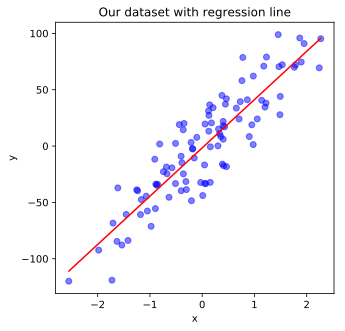

In [37]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='x', ylabel='y')
# plot data on new axis
ax.scatter(X, y, color='blue', alpha=0.5)
# plot regression line
ax.plot(X, y_pred, color='red')
ax.set_title('Our dataset with regression line')
# display plot
plt.show()

**Question:** To quantify the error, we can use the mean square error (MSE). Implement this the quadratic loss function given above:

In [41]:
def mean_square_error(X, y, beta):
    y_pred = np.dot(X, beta)
    res = 0
    for Y, Y_pred in zip(y, y_pred) :
        res += np.square(Y - Y_pred)
    return res/len(y)

mse = mean_square_error(X_bt, y, beta)
print('MSE: %.02f RMSE: %.02f' % (mse, np.sqrt(mse)))

MSE: 456.69 RMSE: 21.37


Note the closeness of the RMSE and the noise parameter we used to create the dataset.

### Gradient Descent

A closed-form solution like least squares will not always be available to us, however, and we instead consider numerical optimisation techniques. *Gradient descent* finds a convex minimum by making progressive steps in the direction opposite the gradient. That is,

$$\boldsymbol\beta_{k+1} = \boldsymbol\beta_{k} - \alpha\nabla_{\boldsymbol\beta}\mathcal{L}$$

for each iteration $k$ and some step size $\alpha$, known as the *learning rate*.

#### Batch gradient descent

To perform a gradient descent, we need to be able to query the gradient at each iteration. Therefore, we implement a function to evaluate the gradient. The gradient of a linear regression is,

$$\nabla_{\boldsymbol\beta}\mathcal{L} = \frac{1}{N}\mathbf{X}^T(\mathbf{X}\boldsymbol\beta - y)$$

which is an $\mathcal{O}(ND)$ computation.

**Question**: Implement a function to compute the gradient:

In [120]:
def evaluate_gradient(X, y, beta):
    return (1/len(y)) * np.dot(X.transpose(), (np.dot(X, beta) - y))

To validate the function, let's look at the gradient at our least squares solution (it should be zero):

In [44]:
from numpy.linalg import norm
print(norm(evaluate_gradient(X_bt, y, beta)))

5.934733498339057e-15


**Question**: Now we implement a batch gradient descent algorithm. Fill in the gradient update step where indicated:

In [45]:
def batch_gradient_descent(X, y, lr=1e-1, max_iters=30, tol=1e-2):
    # randomly initialise beta
    N, D = X.shape
    beta = np.random.rand(D)
    # initialise histories
    losses = [mean_square_error(X, y, beta)]
    betas = [beta.copy()]

    for i in range(max_iters):
        grad = evaluate_gradient(X, y, beta)
        beta = beta - lr*grad
        loss = mean_square_error(X, y, beta)
        losses.append(loss)
        betas.append(beta.copy())

        if np.sqrt(grad.dot(grad)) < tol: break

    return np.array(betas), np.array(losses)

Now let's run it on our data. Note the final parameters. How close are they to the OLS solution?

In [46]:
# Run batch gradient descent
betas, losses = batch_gradient_descent(X_bt, y)
print(betas[-1])

[-1.18450953 41.10830941]


Let's visualise our gradient descent:

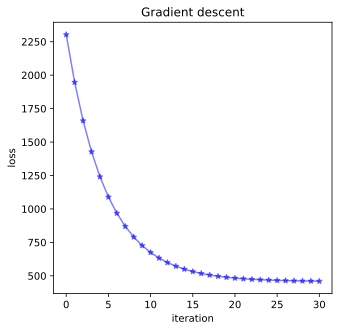

In [47]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='iteration', ylabel='loss')
# plot data on new axis
ax.plot(losses, color='blue', marker='*', alpha=0.5)
ax.set_title('Gradient descent')
# display plot
plt.show()

Finally, let's make a nice 3-dimensional plot of our gradient descent:

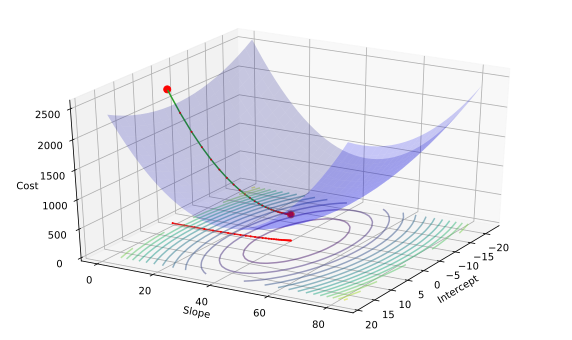

In [56]:
from mpl_toolkits.mplot3d import Axes3D

# create meshgrid
ms = np.linspace(beta[0] - 20 , beta[0] + 20, 20)
bs = np.linspace(beta[1] - 40 , beta[1] + 40, 40)
M, B = np.meshgrid(ms, bs)
zs = np.array([mean_square_error(X_bt, y, theta)
               for theta in zip(np.ravel(M), np.ravel(B))])
Z = zs.reshape(M.shape)

# create 3D axis object
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d', xlabel='Intercept',
                     ylabel='Slope', zlabel='Cost')

# plot mse loss hypersurface and contours
ax.plot_surface(M, B, Z, rstride=1, cstride=1, color='b', alpha=0.2)
ax.contour(M, B, Z, 20, color='b', alpha=0.5, offset=0, stride=30)

# plot start and end points
ax.plot([betas[0][0]], [betas[0][1]], [losses[0]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);
ax.plot([betas[-1][0]], [betas[-1][1]], [losses[-1]] , markerfacecolor='r', marker='o', markersize=7);

# plot gradient descent curves
ax.plot(betas[:, 0], betas[:, 1], losses, markeredgecolor='r', marker='.', markersize=2);
ax.plot(betas[:, 0], betas[:, 1], 0, markeredgecolor='r', marker='.', markersize=2);

# set viewpoint
ax.view_init(elev=30, azim=30)

plt.show()

#### Strong Convexity

Strong convexity implies a quadractic lower bound on a function. A multivariate function $\mathcal{L}(\boldsymbol\beta)$ is $\mu$-strongly convex iff $\nabla_{\boldsymbol\beta\boldsymbol\beta}\mathcal{L} \succeq \mu$ for $\mu > 0$, that is, its Hessian matrix is positive definite. The gradient descent of a strongly convex function is guaranteed convergence with,

$$\mathcal{L}(\boldsymbol\beta_t) - \mathcal{L}(\boldsymbol\beta_*) \leq (1 - \mu/L)^{2t}[\mathcal{L}(\boldsymbol\beta_t) - \mathcal{L}(\boldsymbol\beta_*)]$$

where $\boldsymbol\beta_t$ is the parameter vector at iteration $t$, $\boldsymbol\beta_*$ are the optimal parameters, and $\mu$ and $L$, used as the learning rate, are respectively the smallest and largest eigenvalues of the $\mathcal{L}$. That is, the *regret* converges exponentially to zero by the iteration.

**Question:** A matrix is positive definite iff its eigenvalues are strictly positive. For our quadratic loss function, the Hessian matrix, also known as the Gram matrix, is given by $$\nabla_{\beta\beta}\mathcal{L} = \frac{1}{N}\mathbf{X}^T\mathbf{X}$$

Compute the eigenvalues of the Gram matrix and verify the strong convexity of our regression's quadratic loss:

In [58]:
from numpy.linalg import eigvals
eigens = eigvals((1/N)*np.dot(X_bt.T, X_bt))
print(eigens)

[0.94911201 1.07029161]


**Question:** Calculate a range of gradient descent losses including $1/L$, where $L$ is the largest eigenvalue.

In [77]:
lr = [1e-1, 1.2, 1/max(eigens)] # TODO: Create a list of three learning rates including the theoretical 1/L
# Now we run gradient descent for each
_, losses1 = batch_gradient_descent(X_bt, y, lr=lr[0])
_, losses2 = batch_gradient_descent(X_bt, y, lr=lr[1])
_, losses3 = batch_gradient_descent(X_bt, y, lr=lr[2])

Now we will visualise the losses. This time we use a log scale so as to observe the exponential improvement towards the least squares solution. We subtract the optimal mse computed above so that the losses converge to 0:

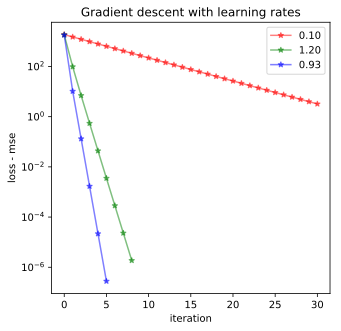

In [78]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='iteration', ylabel='loss - mse')
# plot data on new axis
ax.plot(losses1 - mse, color='red', marker='*', alpha=0.5, label='%.02f' % lr[0])
ax.plot(losses2 - mse, color='green', marker='*', alpha=0.5, label='%.02f' % lr[1])
ax.plot(losses3 - mse, color='blue', marker='*', alpha=0.5, label='%.02f' % lr[2])
ax.set_title('Gradient descent with learning rates')
ax.set_yscale('log')
# add legend
plt.legend()
# display plot
plt.show()

Try different learning rates (e.g. higher and lower) and observe the effects.

## Problem #2 - binary classification

For this problem, we will use an external dataset. Download the following: http://www.di.ens.fr/%7Efbach/orsay2017/data_orsay_2017.mat. Although a MATLAB file, we can use a handy scipy routine to read the data:

In [79]:
from scipy import io
data = io.loadmat('data_orsay_2017.mat')

We extract the relevant data from this dictionary object and print its dimensions:

In [80]:
X_train, y_train = data['Xtrain'], data['ytrain']
X_test, y_test = data['Xtest'], data['ytest']

print('X_train shape: %s' % str(X_train.shape))
print('y_train shape: %s' % str(y_train.shape))
print('X_test shape: %s' % str(X_test.shape))
print('y_test shape: %s' % str(y_test.shape))

X_train shape: (10000, 100)
y_train shape: (10000, 1)
X_test shape: (100000, 100)
y_test shape: (100000, 1)


Once again we perform the bias trick:

In [81]:
X_train_bt = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test_bt = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

In a logistic regression we encode the positive and negative classes as $y \in \{-1, 1\}$. Then, $p(y = 1|\mathbf{x}^T\boldsymbol\beta) = \sigma(\mathbf{x}^T\boldsymbol\beta)$ and $p(y = -1|\mathbf{x}^T\boldsymbol\beta) = 1 - \sigma(\mathbf{x}^T\boldsymbol\beta) = \sigma(-\mathbf{x}^T\boldsymbol\beta)$, where $\sigma(x) = 1/(1 + \exp(-x))$ is the *sigmoid* or *logistic* function. To learn the model, we minimise the mean cross-entropy between the predicted distribution and the ground truth, which we can take to be *one-hot*, putting all probability on the correct class. This simplifies the loss function to,

$$\frac{1}{N}\sum_{i=1}^N\log(1 + \exp(-y_i\mathbf{x}^T\boldsymbol\beta))$$

**Question:** Implement the loss function of a logistic regression:

In [194]:
from numpy import log, exp

def log_loss(X, y, beta):
    res = 0
    for i in range(len(y)) :
        print(np.dot(X, beta))
        print(np.dot(X, beta).shape)
        res += log(1 + exp(-y[i][0]*np.dot(X, beta)))
    return res/len(y)

**Question:** Implement a function to return the logistic loss gradient:

$$\nabla_\beta\mathcal{L} = \sum_{i=1}^N \frac{-\mathbf{x}_i\cdot y_i}{1 + \exp(y_i\mathbf{x}_i^T\beta)}$$

In [180]:
def evaluate_gradient_compliquee(X, y, beta):
    res = 0
    for i in range(len(y)) :
        res += -X[i]*y[i] / (1 + exp(y[i] * X[i] * beta))
    return res

### Stochastic gradient descent

In larger applications, computing the full gradient can be expensive. Moreover, a sample of size $M < N$ from a large dataset at each iteration is often sufficient to make an accurate descent step. *Minibatch gradient descent* uses a size $M$ subsample of the data at each iteration. In the extreme case that $M = 1$ we have what is known as *stochastic gradient descent*. The gradient computation therefore goes from a complexity of $\mathcal{O}(ND)$ to $\mathcal{O}(MD)$. In the training of deep neural networks, minibatch gradient descent (and its variants) is overwhelmingly the most popular approach, where a stochastic element additionally may help to avoid local minima of their non-convex loss functions.

Operationally, the only thing that changes is the amount of data, we feed our gradient function, what we will call the *batch*. The most obvious strategy for selecting a batch is to cycle through the (pre-shuffled) data and slice the next $M$ values. Thus, at iteration $i$, we calculate the gradient as,

$$\nabla_{\beta}\mathcal{L}_{\text{batch}} = \frac{1}{M}\mathbf{X}_{i:i+M}^T(\mathbf{X}_{i:i+M}\beta - y_{i:i+M})$$

A full cycle of the training data is known as an *epoch*.

**Question:** Implement a cycling strategy for `minibatch_gradient_descent` with a given `batch_size`:

In [181]:
def minibatch_gradient_descent(X, y, batch_size=10, lr=1e-1, max_iters=1000, tol=1e-5):
    # randomly initialise beta
    N, D = X.shape
    beta = np.random.rand(D, 1)
    # initialise history variables
    losses = [log_loss(X, y, beta)]
    betas = [beta]

    for i in range(max_iters):
        batchX = X[i:i+batch_size]
        batchY = y[i:i+batch_size]
        print(batchY)
        print(batchY.shape)
        grad = evaluate_gradient(batchX, batchY, beta)
    #   grad = grad[:, np.newaxis]
        beta -= lr*grad
        loss = log_loss(X, y, beta)
        print(loss)
        losses.append(loss)
        betas.append(beta.copy())

        if np.sqrt(grad.T.dot(grad)) < tol: break

    return betas, losses

Now we run minibatch gradient descent on our problem:

In [195]:
# Run batch gradient descent
betas, losses = minibatch_gradient_descent(X_train_bt, y_train, max_iters=10, batch_size=10, lr=1e-0)

[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(

(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.9

(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.9

[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(

(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.9

[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(

(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.9

[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(

[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(

(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.93329744]]
(10000, 1)
[[0.97728692]
 [1.53682248]
 [1.48017011]
 ...
 [1.57853287]
 [1.55741856]
 [0.9

KeyboardInterrupt: 

[array([[0.70853813],
       [1.05236417],
       [0.81094011],
       ...,
       [1.21939871],
       [1.10345481],
       [0.79481588]]), array([[0.69638043],
       [0.6937775 ],
       [0.70264153],
       ...,
       [1.11599633],
       [0.72192381],
       [0.78724153]]), array([[0.69810183],
       [0.75942987],
       [0.69489075],
       ...,
       [0.89454118],
       [0.70040607],
       [0.75846612]]), array([[0.70974056],
       [0.93264856],
       [0.71543814],
       ...,
       [0.80337823],
       [0.71984504],
       [0.77343663]]), array([[0.81426184],
       [0.74746121],
       [0.69586447],
       ...,
       [0.69697431],
       [0.7208038 ],
       [0.69805437]]), array([[0.69714312],
       [0.71119595],
       [0.70303379],
       ...,
       [0.78106017],
       [0.69438346],
       [0.69353507]]), array([[0.69442993],
       [0.6932307 ],
       [0.69364232],
       ...,
       [0.74523496],
       [0.69409086],
       [0.71637745]]), array([[0.83663645]

ValueError: x and y can be no greater than 2-D, but have shapes (21,) and (21, 10000, 1)

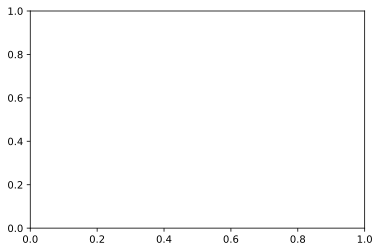

In [152]:
print(losses)
plt.plot(range(len(losses)), losses)
plt.show()

**Question:** Calculate probabilties $\hat{\mathbf{p}} = \sigma(\mathbf{X}{\beta})$ on our test data using the learned parameters. Use scipy's `expit` function or implement the sigmoid yourself:

In [142]:
from scipy.special import expit
beta = betas[-1]
probs = expit(np.dot(X_test_bt, beta))

For each test sample $\mathbf{x}_i$ the logistic function returns a probability $p_i \in [0, 1]$. To make a prediction, we threshold the probabilities at 0.5: any probabilty $\geq0.5$ we will say is positive; any $<0.5$ negative. Because we chose to encode our outputs as $y \in {-1, 1}$, we will map our positives and negatives to $1$ and $-1$ respectively.

In [143]:
y_pred = list(map(lambda x : 1 if x >= 0.5 else -1, probs))

Now we can check the accuracy of our model:

In [144]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.49914

**Question:** Choose different batch sizes. Try $M = 1$ for pure stochastic gradient descent and try a large batch size for comparison:

In [ ]:
bs = [] # TODO: Create list of different batch sizes including M = 1
_, losses1 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[0])
_, losses2 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[1])
_, losses3 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[2])

Let's visualise our descent curves:

In [ ]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='iteration', ylabel='loss')
# plot data on new axis
ax.plot(losses1, color='red', marker='.', alpha=0.5, label='M = %s'%bs[0])
ax.plot(losses2, color='green', marker='.', alpha=0.5, label='M = %s'%bs[1])
ax.plot(losses3, color='blue', marker='.', alpha=0.5, label='M = %s'%bs[2])
ax.set_title('Stochastic gradient descent')
# display lengend
plt.legend()
# display plot
plt.show()

**Question:** An alternative to our cycling strategy is to randomly sample a batch at each iteration. Numpy's `randint` function can be used to sample integers (with replacement) from a range. Use this to implement a sampling strategy for minibatch gradient descent:

In [ ]:
from numpy.random import randint

def minibatch_gradient_descent_sampling(X, y, batch_size=10, lr=1e-1, max_iters=1000, tol=1e-5):
    # randomly initialise beta
    N, D = X.shape
    beta = np.random.rand(D, 1)
    # initialise history variables
    losses = [log_loss(X, y, beta)]
    betas = [beta]

    for i in range(max_iters):
        batchX = # TODO: randomly sample batch
        batchY = # TODO: randomly sample batch
        grad = evaluate_gradient(batchX, batchY, beta)
        grad = grad[:, np.newaxis]
        beta = # TODO: perform gradient descent step (as before)
        if i % 10 == 0:
            loss = log_loss(X, y, beta)
            losses.append(loss)
        betas.append(beta.copy())

        if np.sqrt(grad.T.dot(grad)) < tol: break

    return betas, losses

Now we will compare the two strageties:

In [ ]:
bs = [1, 10]
_, losses1 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[0])
_, losses2 = minibatch_gradient_descent_sampling(X_train, y_train, batch_size=bs[0])
_, losses3 = minibatch_gradient_descent(X_train, y_train, batch_size=bs[1])
_, losses4 = minibatch_gradient_descent_sampling(X_train, y_train, batch_size=bs[1])

Finally, we visualise:

In [ ]:
# create figure
fig = plt.figure(figsize=(5, 5))
# add subplot (rows, cols, number)
ax = fig.add_subplot(1, 1, 1, xlabel='iteration', ylabel='loss')
# plot data on new axis
ax.plot(losses1, color='red', marker='.', alpha=0.5, label='Cycling (M = %d)' % bs[0])
ax.plot(losses2, color='blue', marker='.', alpha=0.5, label='Sampling (M = %d)' % bs[0])
ax.plot(losses3, color='red', marker='*', alpha=0.5, label='Cycling (M = %d)' % bs[1])
ax.plot(losses4, color='blue', marker='*', alpha=0.5, label='Sampling (M = %d)' % bs[1])
# display plot
ax.set_title('Cycling vs. sampling minibatch gradient descent')
plt.legend()
plt.show()